In [1]:
import os
import random
import numpy as np
print("hello")
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

hello


2024-03-26 18:20:27.512946: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 18:20:27.515763: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 18:20:27.556479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 18:20:28.284686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

# Creating paths to appropriate images

In [3]:
class ContrastiveGenerator:
    def __init__(self, datasetPath, number_of_pairs):       #number_of_pairs : number of iterations in loop next_get_item()
        # empty list that will contain the subdirectory names of products
        # of the dataset directory with more than one image in it
        self.types_of_products = list()
        self.number_of_pairs = number_of_pairs

        #iterate over subdirectories in the main directory:
        for folderName in os.listdir(datasetPath):
            if os.path.isdir(os.path.join(datasetPath, folderName)):
                for filename in os.listdir(os.path.join(datasetPath, folderName)):
                    # jeśli są zdjęcia to je pobierz
                    if filename.lower().endswith(".png"):
                        absoluteFolderName = os.path.join(datasetPath, folderName)
                        self.types_of_products.append(absoluteFolderName) 
                    #w przeciwnym wypadku idź do podfolderu
                    else:
                        absolutFolderName = os.path.join(datasetPath, folderName, filename)
                        self.types_of_products.append(absoluteFolderName)
            # # lub to co poniżej : jeśli jest folder bez podfolderów
            # absoluteFolderName = os.path.join(datasetPath, folderName) #datasetPath + "/" + folderName
            # # get the number of images in the subdirectory
            # numImages = len(os.listdir(absoluteFolderName))
            # if numImages > 1:
            #     self.types_of_products.append(absoluteFolderName)

        # create a dictionary of people name to their image names
        self.allProducts = self.generate_all_products_dict()


    # Buildings paths to specific images
    def generate_all_products_dict(self):
        # all_products = dict()
        # for product in self.types_of_products:
        #     if os.path.isdir(product):  # Sprawdź, czy to katalog
        #         image_names = os.listdir(product)
        #         product_photos = [os.path.join(product, imageName) for imageName in image_names]
        #         all_products[product] = product_photos
        # return all_products
        
        # create an empty dictionary that will be populated with
        # directory names as keys and image names as values
        all_products = dict()
        for product in self.types_of_products:
            image_names = os.listdir(product)
            # build the image paths and populate the dictionary
            productsPhotos = [os.path.join(product, imageName) for imageName in image_names]
            all_products[product] = productsPhotos
        print(len(all_products))
        #print(all_products)
        return all_products

    def get_next_element(self):
        for i in range(self.number_of_pairs):
            anchor = random.choice(self.types_of_products)

            # copy the list of products
            temporaryImages = self.types_of_products.copy()
            temporaryImages.remove(anchor)

            # random product from a list of products without anchor
            negativeProduct = random.choice(temporaryImages)

            (anchorProduct, positiveProduct) = np.random.choice(
                a=self.allProducts[anchor],
                size=2,
                replace=False
            )
            # Image from the negative folder
            negativeProduct = random.choice(self.allProducts[negativeProduct])


            yield (anchorProduct, positiveProduct, 0.0)
            yield (anchorProduct, negativeProduct, 1.0)

# Create object for creating dataset

In [4]:
path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
number_of_samples = 32
generator = ContrastiveGenerator(path, number_of_samples)

12


# Generator for creating dataset

In [6]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

In [7]:
print(dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


# Creating dataset


In [8]:
IMAGE_SIZE = (258, 320)



def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_resize_wrapper(image_path1, image_path2,value):
    # return tf.py_function(decode_and_resize, [image_path], tf.float32)
    img1 = decode_and_resize(image_path1)
    img2 = decode_and_resize(image_path2)
    return ((img1, img2), value)

def generate_new_pack_of_images():
    
    # Mapowanie funkcji na oba obrazy
    img_pack = dataset.map(lambda image_path1, image_path2, value: (decode_resize_wrapper(image_path1,image_path2,value)) )
    img_pack = img_pack.batch(batch_size)
    
    #print(list(img_pack))
    return img_pack

    # list_of_products = []
    
    # for (img1, img2), value in img_pack:
    #     list_of_products.append( (img1, img2,value  ))    #value.numpy()
        
    # return list_of_products




# Create new pack of images and labels

In [9]:
touple_of_products = generate_new_pack_of_images()

print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


## show and check if everything is ok ( how to get image from BatchDataset?? )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


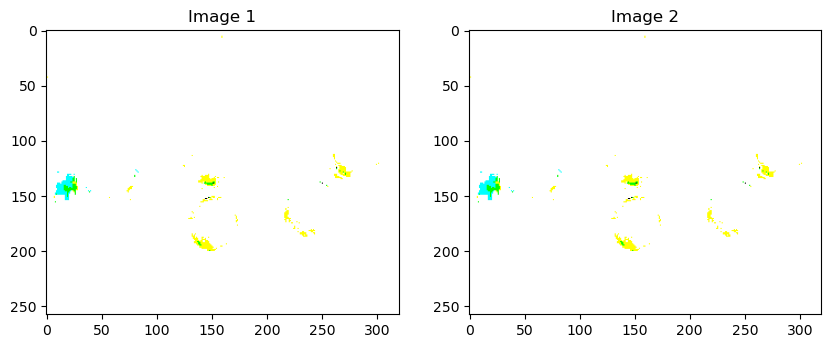

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


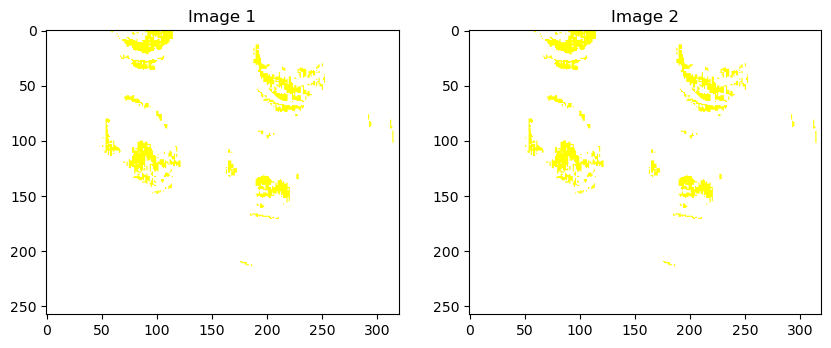

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


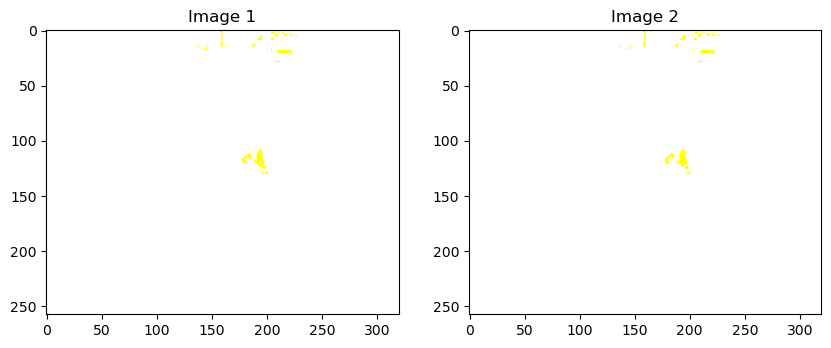

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


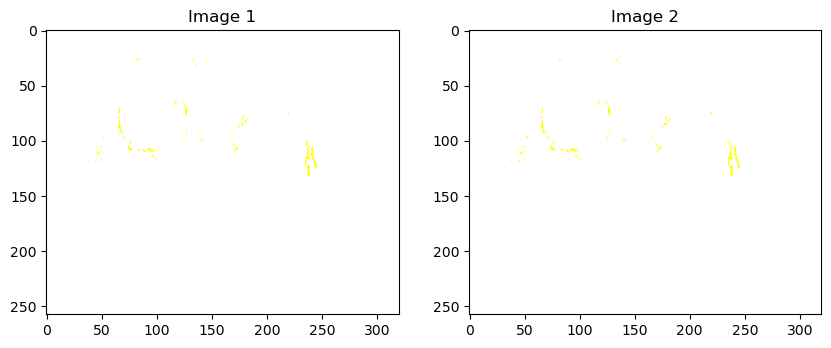

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


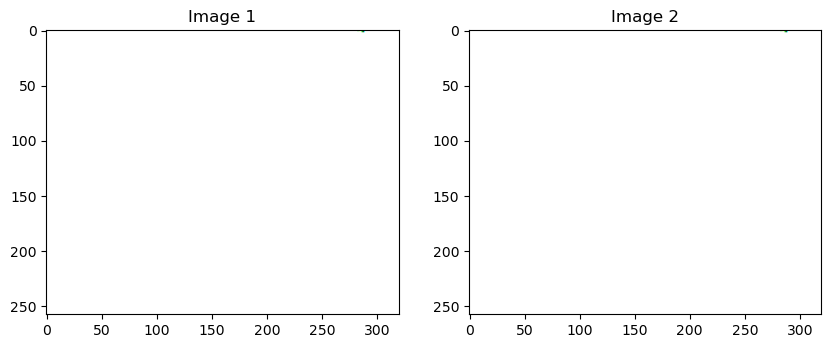

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


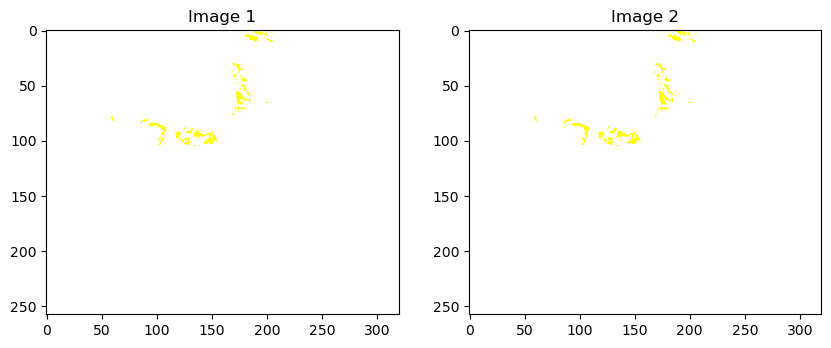

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


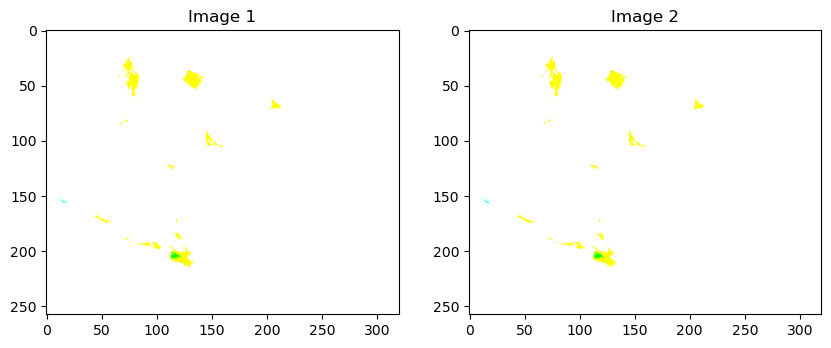

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


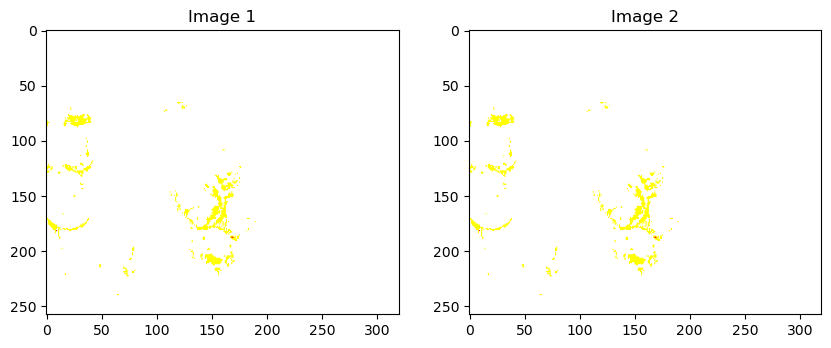

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


2024-03-26 18:22:24.830032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# wyświetlenie obrazów:
import numpy
for img1, label in touple_of_products:

    plt.figure(figsize=(10, 5))
    
    # Obraz 1
    plt.subplot(1, 2, 1)
    plt.imshow(img1[0][0])
    plt.title('Image 1')
    # Obraz 2
    plt.subplot(1, 2, 2)
    plt.imshow(img1[0][1])
    plt.title('Image 2')
    plt.show()
    print("Etykieta:", label)

In [11]:
# img1, img2, label = list_of_products[1]

# # Wyświetlenie obrazów
# plt.figure(figsize=(10, 5))
# # Obraz 1
# plt.subplot(1, 2, 1)
# plt.imshow(img1)
# plt.title('Image 1')
# # Obraz 2
# plt.subplot(1, 2, 2)
# plt.imshow(img2)
# plt.title('Image 2')

# plt.show()
# print("Etykieta:", label)

# Model for learn products distinguish

In [12]:
import keras

def euclidean_distance(vects):
    """
    Znalezienie odległości euklidesowej pomiędzy dwoma wektorami:

    Arguments:
        vects: Lista zawierające dwa tensory tej samej długości

    Returns:
        Tensor containing euclidean distance pomiędzy podanymi wektorami
    """
    x, y = vects

    sum_square = tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True)   
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu

input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Definition of loss function

In [13]:
def loss(margin=1):
    """
    Arguments: 
        margin: Integer, defines the baseline for distance for which pairs
        shoud be classified as dissimilar "1"
    Returns:
        tensor with contrastive loss as floating point value
    """
    # 0-same ,  1-different
    
    #contrastive_loss = (1-y_true)*

    def contrastive_loss(y_true, y_pred):
        """Calculate the contrastive loss
        Arguments:
            y_true: List of labels, each label is of type "float32"
            y_pred: List of predictions
            y_pred to przewidywane odległości między parami danych, które model stara się nauczyć
        Returns:
            A tensor containing contrastive loss value (folat)
        """
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss
    

## Compile model with contrastive loss


In [14]:
# Kompilacja modelu z contrastive_loss

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 10)        │  2,118,326 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,118,332 (8.08 MB)

 Trainable params: 1,817,716 (6.93 MB)

 Non-trainable params: 300,616 (1.15 MB)

In [15]:
#train_products_list = touple_of_products[:(int)(0.8*2*number_of_samples)]
#val_products_list = touple_of_products[(int)(0.8*2*number_of_samples) :]

siamese.fit( touple_of_products, 
            #validation_split= imagesyy, 
            batch_size = batch_size,
            epochs = epochs
            )

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.6380 - loss: 0.2228
Epoch 2/10


2024-03-26 18:22:32.495922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/c100rczyk/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.6411 - loss: 0.2346
Epoch 3/10


2024-03-26 18:22:35.712673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - accuracy: 0.5038 - loss: 0.2679
Epoch 4/10


2024-03-26 18:22:38.958722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 0.7441 - loss: 0.2079
Epoch 5/10


2024-03-26 18:22:42.121821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.4037 - loss: 0.2909
Epoch 6/10


2024-03-26 18:22:45.309563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.5869 - loss: 0.2608
Epoch 7/10


2024-03-26 18:22:48.406071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.6237 - loss: 0.2228
Epoch 8/10


2024-03-26 18:22:51.570082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - accuracy: 0.5361 - loss: 0.2454
Epoch 9/10


2024-03-26 18:22:54.746567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.4921 - loss: 0.2593
Epoch 10/10


2024-03-26 18:22:57.921314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.4539 - loss: 0.2690


2024-03-26 18:23:01.046204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Archiwum

In [ ]:
# print(len(train_products_list))
# print(len(val_products_list))

# x_train_1 = []
# x_train_2 = []
# labels_train = []
# x_val_1 = []
# x_val_2 = []
# labels_val = []
# for (img1, img2), label in train_products_list:
#     x_train_1.append(img1)
#     x_train_2.append(img2)
#     labels_train.append(label)
# for (img1, img2), label in val_products_list:
#     x_val_1.append(img1)
#     x_val_2.append(img2)
#     labels_val.append(label)


# print(x_train_1)
# print(labels_train)